<a href="https://ki-campus.org/">
<img border="0" alt="KICampusLogo" src="images/KIcampusLogo.png" width="100" height="30" style="float: right">
</a>

In [2]:
library(learnr)
library(mosaic)
library(tidyr)
library(knitr)
library(ggthemes)

theme.fom <- theme_classic(22*1.04)
theme.fom <- theme.fom
theme_set(
  theme.fom
)

# deutsche Version von random_praise
source("random-praise_de/translation_random-praise_de.R")


# Daten simulieren
set.seed(1896)
n <- 10

Schulung <- tibble(finteresse = rnorm(n)) %>%
  rowwise() %>%
  mutate(pteilnahme = pnorm((finteresse+rnorm(1)))) %>%
  mutate(teilnahme = sample(c("Ja", "Nein"), 
                            size = 1, prob = c(pteilnahme, 1-pteilnahme))) %>%
  mutate(gehalt0 = 2000 * (1 + pnorm((finteresse + rnorm(1)))/10)) %>%
  mutate(gehalt1 = gehalt0 * (0.95 + rbeta(1,1,10))) %>%
  mutate(across(where(is.numeric), ~ round(.x, -2))) %>%
  mutate(effekt = gehalt1 - gehalt0) %>%
  mutate(gehalt = case_when(teilnahme == "Ja" ~ gehalt1,
                            teilnahme == "Nein" ~ gehalt0)) %>%
  ungroup() %>%
  mutate(i=row_number()) %>%
  select(i, teilnahme, gehalt0, gehalt1, effekt, gehalt)

## Lernziele

In diesem Modul lernen Sie:

- was ein **potenzielles Ergebnis (Potential Outcome)** ist;

- was ein **Counterfactual** ist;

- wie **kausale Effekte** definiert werden können;

- warum die Bestimmung von kausalen Effekten so herausfordernd ist.

## Individueller kausaler Effekt

Stellen Sie sich folgende Situation vor: Am Ende Ihrer Ausbildungszeit wird Ihnen die Teilnahme an einer freiwilligen Schulung zum Thema Gehaltsverhandlungen angeboten.

Würden Sie teilnehmen?

Für Ihre Entscheidung ist vermutlich relevant, ob Sie davon ausgehen, dass die Teilnahme Ihr zukünftiges Gehalt tatsächlich verbessern wird.

Wie würden Sie für sich diesen **individuellen kausalen Effekt** der Teilnahme an der Schulung auf Ihr Gehalt definieren, d. h., was *bringt* Ihnen die Schulung finanziell?

*Denken Sie bitte kurz darüber nach und klicken Sie erst dann auf `Weiter`*

##

Eine mögliche Idee wäre es, einfach die Differenz des Gehaltes vor und nach der Schulung zu bilden: *Gehalt nach der Schulung minus Gehalt vor der Schulung*.
Hier ergibt sich aber ein Problem, denn es ist natürlich gut möglich, dass unabhängig von der Schulung Ihr Gehalt mit der Zeit angestiegen wäre. 

(Eine ganz ähnliche Situation ergibt sich, wenn man zum Beispiel rausfinden möchte, ob ein bestimmtes Medikament gegen eine Krankheit hilft:
Einige Erkrankungen werden von alleine mit der Zeit besser und es wäre ein Fehler, diese Verbesserung spezifischen Maßnahmen zuzuschreiben.
Daher spielen Kontrollgruppen in klinischen Studien eine so zentrale Rolle.)

Eine andere Möglichkeit ist es, diesen Effekt als 

$$\text{Gehalt mit Schulung} - \text{Gehalt ohne Schulung}$$

zu definieren.

Wenn Sie vor der Entscheidung stehen: *Nehme ich an der Schulung teil?* gibt es für Ihr Gehalt zwei **potenzielle Ergebnisse (englisch: Potential Outcomes)**:

- $\color{blue}{\text{Gehalt}}$ ohne $\color{DarkGreen}{\text{Schulung}}$: $\color{blue}{Y}^{\color{DarkGreen}{X=0}}$

- $\color{blue}{\text{Gehalt}}$ mit $\color{DarkGreen}{\text{Schulung}}$: $\color{blue}{Y}^{\color{DarkGreen}{X=1}}$

$\color{blue}{Y}$ ist die *Wirkung*, das Ergebnis, also hier das $\color{blue}{\text{Gehalt}}$.
Das hochgestellte $\color{DarkGreen}{X}$ soll symbolisieren für welche Wert der *Ursache* das Ergebnis betrachtet wird.
Ohne $\color{DarkGreen}{\text{Schulung}}$ nimmt $\color{DarkGreen}{X}$ den Wert 0 an, mit $\color{DarkGreen}{\text{Schulung}}$ den Wert 1.

![](images/Weggabel.png){width="65%"}

##

Der **individuelle kausale Effekt** ${\color{orange}{\Delta}}_i$ (griechisch: Delta) der Schulung ergibt sich dann als die Differenz zwischen diesen beiden potenziellen Ergebnissen:

$${\color{orange}{\Delta}}_i = {\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=1}}} - {\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=0}}}$$

Wobei

- $i$ für die einzelne Beobachtung, hier die einzelne Person, steht;

- ${\color{blue}{Y}}_i$ für das $\color{blue}{\text{Gehalt}}$ von $i$;

- $\color{DarkGreen}{X}$ für die Teilnahme an der $\color{DarkGreen}{\text{Schulung}}$; dabei ist $\color{DarkGreen}{X_i=1}$ wenn $i$ teilnimmt und $\color{DarkGreen}{X_i=0}$ wenn $i$ nicht teilnimmt.

## Ein fiktives Beispiel

Schauen wir uns einmal eine fiktive Gehaltstabelle mit potenziellen Ergebnissen an:

- `i`: Nummer der Person;

- `gehalt1`: $\color{blue}{Y}^{\color{DarkGreen}{X=1}}$, Gehalt mit Schulung;

- `gehalt0`: $\color{blue}{Y}^{\color{DarkGreen}{X=0}}$, Gehalt ohne Schulung.

In [3]:
Schulung %>%
  select(i, gehalt1, gehalt0) %>%
  kable()



|  i| gehalt1| gehalt0|
|--:|-------:|-------:|
|  1|    2300|    2200|
|  2|    2200|    2000|
|  3|    2100|    2000|
|  4|    2500|    2100|
|  5|    2500|    2100|
|  6|    2100|    2100|
|  7|    2200|    2100|
|  8|    2000|    2100|
|  9|    2000|    2000|
| 10|    2100|    2100|

Der individuelle kausale Effekt ${\color{orange}{\Delta}}_i$ lässt sich dann innerhalb der Datentabelle `Schulung` berechnen als `gehalt1 - gehalt0` (hier in `R`):

***

*Anmerkung:* `R` ist eine freie Software für die Datenanalyse.
Sie kann von der Seite <https://cran.r-project.org/> für gängige Betriebssysteme heruntergeladen werden.
Ergänzend ist die Nutzung des `RStudio Desktop` empfehlenswert <https://www.rstudio.com/products/rstudio/download/>.
Im Rahmen dieser Module wird außerdem u.a. das Paket `mosaic` <https://cran.r-project.org/package=mosaic> verwendet.

***


In [4]:
# Paket laden
library(mosaic)
# Datentabelle Schulung um neue Variable "effekt" ergänzen
Schulung <- Schulung %>%
  mutate(effekt = gehalt1 - gehalt0)

Und damit:

In [5]:
Schulung %>%
  select(i, gehalt1, gehalt0, effekt) %>%
  kable()



|  i| gehalt1| gehalt0| effekt|
|--:|-------:|-------:|------:|
|  1|    2300|    2200|    100|
|  2|    2200|    2000|    200|
|  3|    2100|    2000|    100|
|  4|    2500|    2100|    400|
|  5|    2500|    2100|    400|
|  6|    2100|    2100|      0|
|  7|    2200|    2100|    100|
|  8|    2000|    2100|   -100|
|  9|    2000|    2000|      0|
| 10|    2100|    2100|      0|

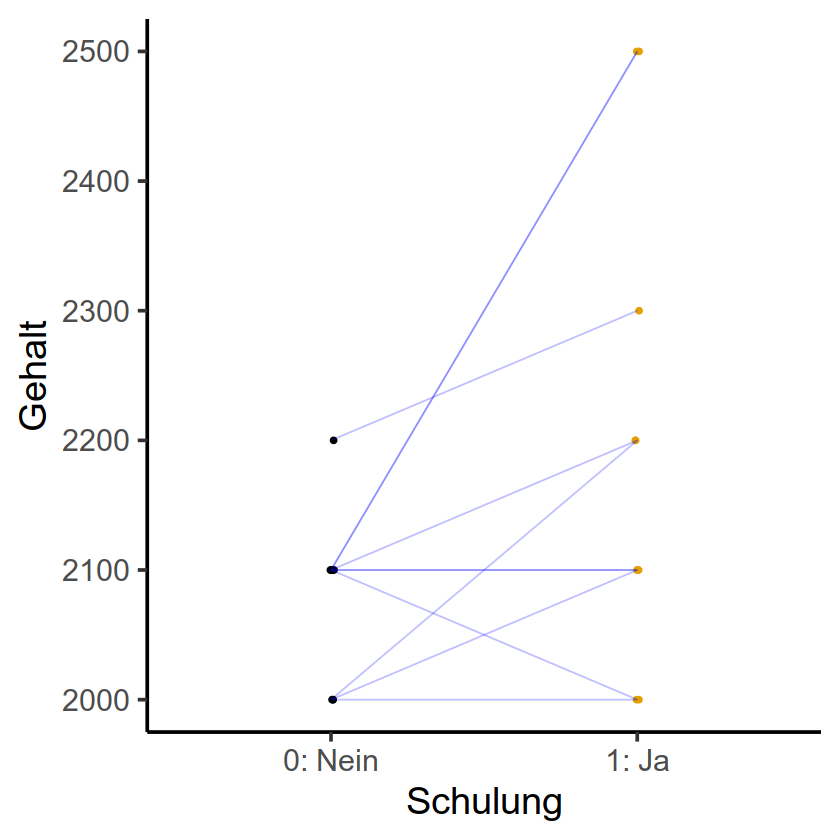

In [6]:
Schulung_Long <- Schulung %>%
  select(i, gehalt0, gehalt1) %>%
  pivot_longer(c(gehalt0, gehalt1), values_to = "Gehalt", names_to = "Schulung") %>%
  mutate(Schulung = ifelse(Schulung == "gehalt0", "0: Nein", "1: Ja"))

gf_point(Gehalt ~ Schulung, data = Schulung_Long,
         position = "jitter", width = 0.01, height = 0,
         color = ~ Schulung,
         show.legend = FALSE) %>%
  gf_line(Gehalt ~ Schulung, group = ~ i,
          color = "blue", alpha = 0.25) +
  scale_color_colorblind()

In [ ]:
question("Können Sie diese individuellen kausalen Effekte in der Realität beobachten?",
         answer("Ja"),
         answer("Nein", correct = TRUE, message = "Für jede Beobachtung $i$ liegt nur ein Gehaltswert vor: der mit Schulung oder der ohne Schulung, aber niemals beide gleichzeitig, da Personen entweder teilnehmen oder nicht. $\\Delta_i$ kann daher nicht beobachtet werden."),
         allow_retry = TRUE,
         correct = random_praise(),
         incorrect = random_encouragement()
         )

Sie sehen: häufig sind die individuellen kausalen Effekte positiv &ndash; sie können aber auch neutral oder sogar negativ sein.

## Das fundamentale Problem der kausalen Inferenz

Das fundamentale Problem der kausalen Inferenz ist, dass wir den individuellen kausalen Effekt ${\color{orange}{\Delta}}_i = {\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=1}}} - {\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=0}}}$ **nicht** beobachten können.
Es liegt je Beobachtung $i$ immer nur eines der beiden Potential Outcomes vor:
Entweder $\color{blue}{Y}^{\color{DarkGreen}{X=1}}$ ($\color{blue}{\text{Gehalt}}$ mit $\color{DarkGreen}{\text{Schulung}}$) **oder** $\color{blue}{Y}^{\color{DarkGreen}{X=0}}$ ($\color{blue}{\text{Gehalt}}$ ohne $\color{DarkGreen}{\text{Schulung}}$).

- Wenn Person $i$ an der Schulung teilnimmt, liegt uns das Gehalt mit Schulung vor, ${\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=1}}}$, und nicht ${\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=0}}}$

- Wenn Person $i$ nicht an der Schulung teilnimmt, liegt uns das Gehalt ohne Schulung vor, ${\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=0}}}$, und nicht ${\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=1}}}$

Der Wert, der nicht beobachtet wird, wird jeweils als **Counterfactual** bezeichnet; er ist kontrafaktisch in dem Sinne, dass er in der Realität nicht vorliegt. 

Für jemanden, der nicht an der Schulung teilgenommen hat, ist das Counterfactual die Antwort auf die Frage: *Wie hoch wäre mein Gehalt, wenn ich an der Schulung teilgenommen hätte?*
Für jemanden der teilgenommen hat, ist das Counterfactual die Antwort auf die Frage: *Wie hoch wäre mein Gehalt, wenn ich nicht an der Schulung teilgenommen hätte?*

In [ ]:
question("Kann das Counterfactual beobachtet werden?",
         answer("Ja", message = "Je Beobachtung $i$ liegt nur ein Wert vor: der mit Schulung oder der ohne Schulung, nicht beide gleichzeitig. Das Counterfactual ist das nicht beobachtete der Potential Outcomes."),
         answer("Nein", correct = TRUE, message = "Das Counterfactual ist das nicht Beobachtete der Potential Outcomes."),
         allow_retry = TRUE,
         correct = random_praise(),
         incorrect = random_encouragement()
         )

In [ ]:
question("Person $i$ nimmt an der Schulung teil. Was ist dann das Counterfactual?",
         answer("$\\color{blue}{Y}^{\\color{DarkGreen}{X=0}}_i$", correct = TRUE, message = "Teilnahme an der Schulung bedeutet $X=1$, d. h. für das Counterfactual $X=0$."),
         answer("$\\color{blue}{Y}^{\\color{DarkGreen}{X=1}}_i$"),
         allow_retry = TRUE,
         correct = random_praise(),
         incorrect = random_encouragement()
         )

## Durchschnittlicher kausaler Effekt

Mal angenommen, wir würden die individuellen kausalen Effekte $\color{orange}{\Delta}_i$ aber doch kennen (Variable `effekt` in unserem `R`-Beispiel).
Dann könnten wir aus ihnen weitere Größen ableiten, beispielsweise den *durchschnittlichen* kausalen Effekt $\bar{\color{orange}{\Delta}}$, indem wir alle $i$ individuellen kausalen Effekte addieren und diese Summe ($\sum$) durch die Anzahl der Beobachtungen ($n$) dividieren: 

$$\bar{\color{orange}{\Delta}} = \frac{\sum_{i=1}^n {\color{orange}{\Delta}}_i}{n} = \frac{\sum_{i=1}^n({\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=1}}} - {\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=0}}})}{n} = \frac{\sum_{i=1}^n{\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=1}}} - \sum_{i=1}^n{\color{blue}{Y}}_{i}^{{\color{DarkGreen}{X=0}}}}{n} = \overline{\color{blue}{Y}}^{{\color{DarkGreen}{X=1}}} - \overline{\color{blue}{Y}}^{\color{DarkGreen}{X=0}}.$$

Die `R`-Funktion, die diesen arithmetischen Mittelwert berechnet, lautet `mean()`.

Klicken Sie auf `Ausführen`, um den durchschnittlichen kausalen Effekt in unserem fiktiven Beispiel zu berechnen, in dem beide Potential Outcomes vorliegen.

In [ ]:
mean( ~ effekt, data = Schulung)

***

*Anmerkung:* In `mosaic` ist die `R`-Syntax vereinheitlicht:

`analyse(y ~ x, data = Daten)`

Analysiere die Variable `y` in Abhängigkeit der Variable `x` aus der Datentabelle `Daten`. Welche Funktion `analyse()` zur Anwendung kommt, hängt vom Ziel unser Analyse ab. 

Sollte es, wie im vorliegenden Fall, nur eine Variable geben, die zusammengefasst werden soll, kann auch kurz geschrieben werden:

`analyse( ~ y, data = Daten)`

***

Beachten Sie: Der durchschnittliche kausale Effekt ist positiv, auf Individualebene kann er aber auch negativ sein. $\bar{\color{orange}{\Delta}}$ ist eine aggregierte Datenzusammenfassung.

##

Das fundamentale Problem der kausalen Inferenz ist, dass nur eines der Potential Outcomes vorliegt und das nicht vorliegende ein Counterfactual ist.
Daher kennen wir in der Praxis weder den individuellen noch den durchschnittlichen kausalen Effekt.
Letzterer liegt in unserem Beispiel bei $\bar{\color{orange}{\Delta}}=\frac{\sum_{i=1}^n \color{orange}{\Delta}_i}{n}$ = `mean(~ effekt, data = Schulung)`.

## Fehlende Werte

In der Praxis kennen wir zwar nicht beide Potential Outcomes, aber wir wissen innerhalb einer Beobachtungsgruppe, wer an der Schulung teilgenommen hat und wer nicht.
Daraus ergibt sich, welches der beiden Potential Outcomes beobachtet ist und welches uns fehlt (das Counterfactual).

In der Praxis sähe unsere fiktive Gehaltstabelle also anders aus -- fehlende Werte werden in `R` als `NA` (engl.: not available, nicht verfügbar) dargestellt.

In [7]:
Schulung %>%
  select(i, teilnahme, gehalt0, gehalt1) %>%
  mutate(gehalt0 = ifelse(teilnahme=="Ja", NA, gehalt0)) %>%
  mutate(gehalt1 = ifelse(teilnahme=="Nein", NA, gehalt1)) %>%
  kable()



|  i|teilnahme | gehalt0| gehalt1|
|--:|:---------|-------:|-------:|
|  1|Ja        |      NA|    2300|
|  2|Ja        |      NA|    2200|
|  3|Ja        |      NA|    2100|
|  4|Nein      |    2100|      NA|
|  5|Ja        |      NA|    2500|
|  6|Ja        |      NA|    2100|
|  7|Ja        |      NA|    2200|
|  8|Nein      |    2100|      NA|
|  9|Nein      |    2000|      NA|
| 10|Nein      |    2100|      NA|

In der Regel strukturiert man die Daten so, dass nur eine Gehaltsvariable -- das beobachtete `gehalt` -- sowie eine Variable zur `teilnahme` existiert.

In [8]:
Schulung %>%
  select(i, teilnahme, gehalt) %>%
  kable()



|  i|teilnahme | gehalt|
|--:|:---------|------:|
|  1|Ja        |   2300|
|  2|Ja        |   2200|
|  3|Ja        |   2100|
|  4|Nein      |   2100|
|  5|Ja        |   2500|
|  6|Ja        |   2100|
|  7|Ja        |   2200|
|  8|Nein      |   2100|
|  9|Nein      |   2000|
| 10|Nein      |   2100|

In [ ]:
question("Die Teilnahme an der Schulung war freiwillig. Können Sie davon ausgehen, dass, unabhängig von der Schulung, Teilnehmende und Nichtteilehmende ein ähnliches erstes Gehalt haben würden?",
         answer("Ja"),
         answer("Nein", correct = TRUE, message = "Teilnehmende und Nichtteilnehmende könnten sich in vielerlei Hinsicht unterscheiden. Um nur ein Beispiel zu nennen: Personen, denen ihr Gehalt besonders wichtig ist, werden eher an der Schulung teilnehmen. Diese Personen werden aber vielleicht auch ohne Schulung anders in Gehaltsverhandlungen auftreten."),
         allow_retry = TRUE,
         correct = random_praise(),
         incorrect = random_encouragement()
         )

## Schätzung des kausalen Effektes

Anhand der tatsächlich beobachteten Daten können wir zwei Durchschnittsgehälter berechnen:
Das Durchschnittsgehalt derjenigen, die teilgenommen haben, und das Durchschnittsgehalt derjenigen, die nicht teilgenommen haben.

In [10]:
round( mean(gehalt ~ teilnahme, data = Schulung), 2)

Ja    Nein 
2233.33 2075.00

<!-- NOTE: Is it possible to use inline code eval here? -->

- $\bar{\color{blue}{y}}^{\color{DarkGreen}{x=1}}$ = `round(mean(gehalt ~ teilnahme, data = Schulung)[1], 2)`

- $\bar{\color{blue}{y}}^{\color{DarkGreen}{x=0}}$ = `round(mean(gehalt ~ teilnahme, data = Schulung)[2], 2)`

***

*Anmerkung*: `round( mean(gehalt ~ teilnahme, data = Schulung), 2)` bedeutet aus `R mosaic` *übersetzt*:

Berechne den arithmetischen Mittelwert (Funktion `mean()`) der Variable `gehalt` ($y$) in Abhängigkeit der Variable `teilnahme` ($x$). Die dazugehörigen Daten sind in der Datentabelle `Schulung`.

***

Nun könnte man versuchen, den durchschnittlichen kausalen Effekt mithilfe dieser beobachteten Werte zu schätzen:

$\bar{\color{blue}{y}}^{\color{DarkGreen}{x=1}} - \bar{\color{blue}{y}}^{\color{DarkGreen}{x=0}}$ = `round(mean(gehalt ~ teilnahme, data = Schulung)[1],2)` - `round(mean(gehalt ~ teilnahme, data = Schulung)[2],2)` = `round(-diffmean(gehalt ~ teilnahme, data = Schulung),2)`

Dieser Wert weicht aber substanziell vom wahren durchschnittlichen kausalen Effekt ab, den wir zuvor mithilfe der Potential Outcomes berechnet hatten: $\bar{\color{orange}{\Delta}}$ = `round(mean(~ effekt, data = Schulung),2)`.
Bei dieser Abweichung handelt es sich um eine systematische Verzerrung, die auch als **Bias** bezeichnet wird.

Der naive Vergleich der Mittelwerte überschätzt hier den wahren durchschnittlichen Effekt.
In unserem fiktiven Beispiel liegt das daran, dass Personen mit einem höherem Gehaltsinteresse eher an der Schulung teilgenommen haben als die mit einem niedrigeren Interesse.

Erstere hätten aber so oder so, also unabhängig von der Schulung, ein höheres Gehalt erhalten.
Hier sind unterschiedliche inhaltliche Erklärungen denkbar (z.B. ein höheres Interesse am Gehalt und damit auch ein anderes Auftreten in Gehaltsverhandlungen).

Kontrollieren Sie diese Aussage, indem Sie den Code so abändern, dass Sie die Mittelwerte der, auch unbeobachteten, Potential Outcomes berechnen.
Diese befinden sich in der gleichen Datentabelle und tragen die Namen `gehalt0` und `gehalt1`:

*Tipp*: Einen Lösungshinweis erhalten Sie über den `Hinweise`-Button über dem R Code.
Anschließend `Nächster Tipp` und Sie sehen die Lösung.

In [9]:
mean(gehalt ~ teilnahme, data = Schulung)

Ja     Nein 
2233.333 2075.000

In [ ]:
cat("Potential Outcomes: Durchschnittliches Gehalt ohne Teilnahme:\n")
cat("Für die, die teilnehmen ('Ja') das Counterfactual.\n")
mean(gehalt0 ~ teilnahme, data = Schulung)
cat("Potential Outcomes: Durchschnittliches Gehalt mit Teilnahme:\n")
cat("Für die, die nicht teilnehmen ('Nein') das Counterfactual.\n")
mean(gehalt1 ~ teilnahme, data = Schulung)

In [ ]:
"gehalt0 bzw. gehalt1 sind die Variablennamen. Ändern Sie die Variable gehalt entsprechend."

##

Das fundamentale Problem der kausalen Inferenz ist universell.
In vielen Situationen kann es dazu führen, dass die Daten uns in die Irre führen: Vielleicht vermuten wir einen kausalen Effekt, wo es nicht wirklich einen gibt, oder wir erkennen real existierende Effekte nicht. 

Die Gefahr solcher Fehlschlüsse verringert sich aber, wenn wir uns darüber Gedanken machen, wie unsere Daten überhaupt entstanden sind.
In unserem fiktiven Beispiel kann man die zusätzliche Information heranziehen, dass Personen sich frei auswählen konnten, ob sie teilnehmen oder nicht.
Dann erkennt man schnell, dass der naive Mittelwertvergleich kein angemessener Weg ist, den durchschnittlichen kausalen Effekt zu schätzen.

In den folgenden Modulen werden Sie verschiedene datengenerierende Mechanismen kennenlernen und erfahren, wie diese kausale Schlüsse beeinflussen.

## Hinweis

**Dieser Kurs ist aktuell noch in der Entwicklung!**

Bitte melden Sie Fehler, Unklarheiten und Verbesserungsvorschläge [hier](https://github.com/luebby/WWWEKI/issues).

Das Vorhaben *Was, wie, warum? Einstiegskurs Kausale Inferenz (WWWEKI)* wird mit Mitteln des Bundesministeriums für Bildung und Forschung unter dem Förderkennzeichen 16DHBQP040 gefördert.

![](images/csm_Logo-BMBF.jpg)

